In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

## Data preprocessing

In [2]:
# get data
from ler.utils import append_json, load_json
import numpy as np
unlensed_params = load_json("jointnewL1.json")
snr = np.array(unlensed_params['V1'])

In [3]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR
gwsnr = GWSNR(gwsnr_verbose=False)

psds not given. Choosing bilby's default psds
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/halfSNR_dict_0.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/halfSNR_dict_0.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/halfSNR_dict_0.pickle


In [4]:
# get half_snr 
# open pickle file
import pickle
with open('./interpolator_pickle/V1/halfSNR_dict_0.pickle', 'rb') as f:
    half_snr = pickle.load(f)

In [25]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output(idx, params):

    det_idx = 2 # V1

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_halfsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]
    phi_12 = np.array(params['phi_12'])[idx]
    phi_jl = np.array(params['phi_jl'])[idx]

    # input data
    # X = np.vstack([V1, amp0, Mc, eta, theta_jn, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T
    X = np.vstack([snr_half_[det_idx], amp0[det_idx], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T

    # output data
    # get V1 snr for y train 
    y = snr[idx]

    return(X,y)

In [26]:
# training set
unlensed_params.keys()

dict_keys(['zs', 'geocent_time', 'ra', 'dec', 'phase', 'psi', 'theta_jn', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'mass_1', 'mass_2', 'L1', 'H1', 'V1', 'optimal_snr_net'])

In [27]:
len(snr)

76932

In [28]:
# snr_min = 6.
# snr_max = 10.
# bool_ = (snr>snr_min) & (snr<snr_max) 

len_ = len(snr)
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)

In [29]:
X, y = input_output(idx, unlensed_params)

In [30]:
np.shape(X)

(76932, 9)

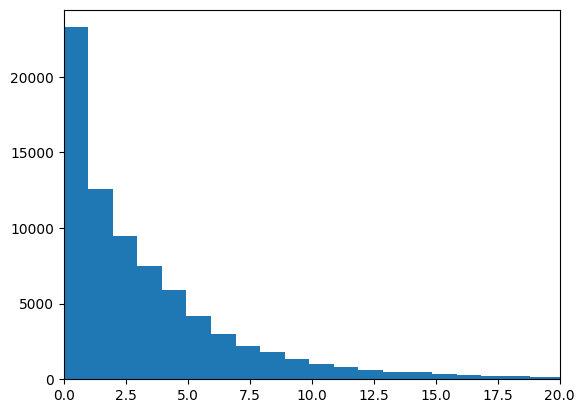

In [31]:
import matplotlib.pyplot as plt
plt.hist(y[y<100], bins=100)
plt.xlim(0,20)
plt.show()

## Now back to ANN

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)


In [33]:
print(np.shape(X_train))
print(np.shape(X_test))

(69238, 9)
(7694, 9)


In [34]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [35]:
X_train[0]

array([ 0.00995559, -0.1384313 ,  0.38201454, -1.48453897,  0.78456132,
       -0.28006214, -0.35041215,  1.37982486, -1.62495746])

In [36]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=9, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [37]:
# compile the ANN
# loss = 'mean_squared_error'
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [38]:
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 100, epochs = 100, workers=4, use_multiprocessing=True)

Epoch 1/100
693/693 [==============================] - 1s 513us/step - loss: 769.0553 - accuracy: 7.5103e-04
Epoch 2/100
693/693 [==============================] - 0s 492us/step - loss: 755.6497 - accuracy: 0.0028
Epoch 3/100
693/693 [==============================] - 0s 497us/step - loss: 750.7309 - accuracy: 0.0041
Epoch 4/100
693/693 [==============================] - 0s 499us/step - loss: 748.0815 - accuracy: 0.0048
Epoch 5/100
693/693 [==============================] - 0s 580us/step - loss: 746.2620 - accuracy: 0.0050
Epoch 6/100
693/693 [==============================] - 0s 493us/step - loss: 744.8391 - accuracy: 0.0050
Epoch 7/100
693/693 [==============================] - 0s 491us/step - loss: 743.6626 - accuracy: 0.0051
Epoch 8/100
693/693 [==============================] - 0s 490us/step - loss: 742.5464 - accuracy: 0.0052
Epoch 9/100
693/693 [==============================] - 0s 490us/step - loss: 741.5853 - accuracy: 0.0052
Epoch 10/100
693/693 [=============================

In [39]:
y_pred = ann.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:20])

241/241 [==============================] - 0s 292us/step
[[ 1.49640989  1.42308143]
 [ 3.53314638  3.94127137]
 [ 1.49089384  1.51867574]
 [14.98836708 14.38981664]
 [ 4.92609692  5.3401403 ]
 [ 0.82437038  0.90605321]
 [ 3.27437425  2.96559695]
 [ 3.44209051  3.65299296]
 [ 1.85034704  1.96655435]
 [ 0.56909704  0.50144454]]


In [40]:
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 1.20%


7694
2351


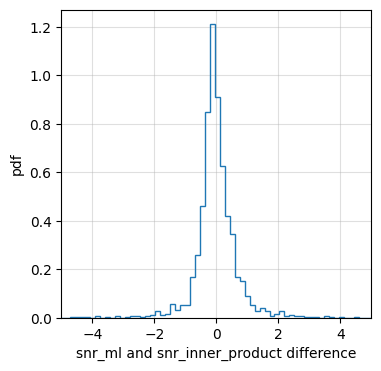

In [41]:
import matplotlib.pyplot as plt
y_pred = y_pred.flatten()
hist_ = y_pred-y_test
print(len(hist_))
idx = (y_test>4) & (y_test<100)
hist_ = hist_[idx]
#hist_ = hist_[abs(hist_)<5.]
print(len(hist_))
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=100, histtype='step', density=True)
plt.xlim(-5,5)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()

In [22]:
# Save the model to a file
ann.save('ann_modelV1.h5')

# Load the model from the file
from tensorflow.keras.models import load_model
model = load_model('ann_modelV1.h5')


In [23]:
model.predict(X_test)

241/241 [==============================] - 0s 369us/step


array([[1.1500559 ],
       [0.5099554 ],
       [0.91778517],
       ...,
       [0.5366888 ],
       [4.2308354 ],
       [1.4608264 ]], dtype=float32)

In [140]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

ValueError: continuous is not supported